<a href="https://colab.research.google.com/github/DinoDx/VoiceCraft/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title #Install and Import

#@markdown Install ddsp, define some helper functions, and download the model. This transfers a lot of data and _should take a minute or two_.
print('Installing from pip package...')
!pip install crepe
!pip install ddsp
!pip install tensorflow_probability==0.12.2

# Ignore a bunch of deprecation warnings
import warnings
warnings.filterwarnings("ignore")

import copy
import os
import time

import crepe
import ddsp
import ddsp.training
from ddsp.colab.colab_utils import (
    auto_tune, get_tuning_factor, download,
    play, record, specplot, upload,
    DEFAULT_SAMPLE_RATE)
from ddsp.training.postprocessing import (
    detect_notes, fit_quantile_transform
)
import gin
from google.colab import files
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

# Helper Functions
sample_rate = DEFAULT_SAMPLE_RATE  # 16000


print('Done!')

Installing from pip package...
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.4/323.4 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.2/217.2 kB 5.8 MB/s eta 0:00:00
  Created wheel for crepe: filename=crepe-0.0.13-py3-none-any.whl size=134848695 sha256=eb6aa6eede791831127791a73c2a2ea423f8952f6b8b141212c308a10633f3a0
  Stored in directory: /root/.cache/pip/wheels/8d/26/87/587cefeb29cc18227d323809c16de9ca64495f527418d5eb06
  Created wheel for resampy: filename=resampy-0.2.2-py3-none-any.whl size=320711 sha256=76631c4132b8ac04dac4b44821edb10173bde755dca7a3932141fa7a0c61e732
  Stored in directory: /root/.cache/pip/wheels/e5/a0/79/29e61754e5b3941ad4c7d01bf5bea99768e64e4bdd3180f32b
Successfully built crepe resampy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.8/213.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 14.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow_probability
    Found existing installation: tensorflow-probability 0.20.1
    Uninstalling tensorflow-probability-0.20.1:
      Successfully uninstalled tensorflow-probability-0.20.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.6 requires tensorflow-probability>=0.13.0, but you have tensorflow-probability 0.12.2 which is incompatible.
Done!


Starting recording for 10 seconds...


<IPython.core.display.Javascript object>

Finished recording!

Extracting audio features...


Audio features took 3.2 seconds


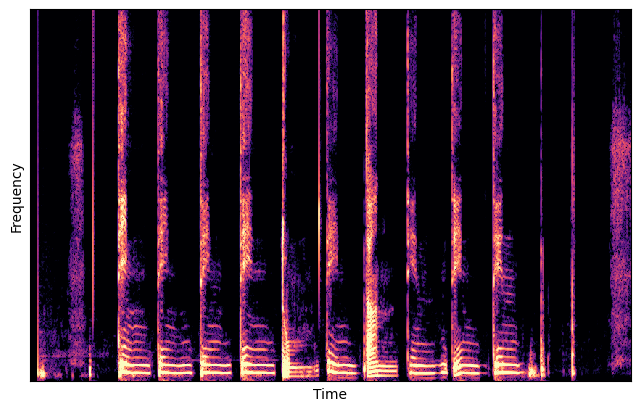

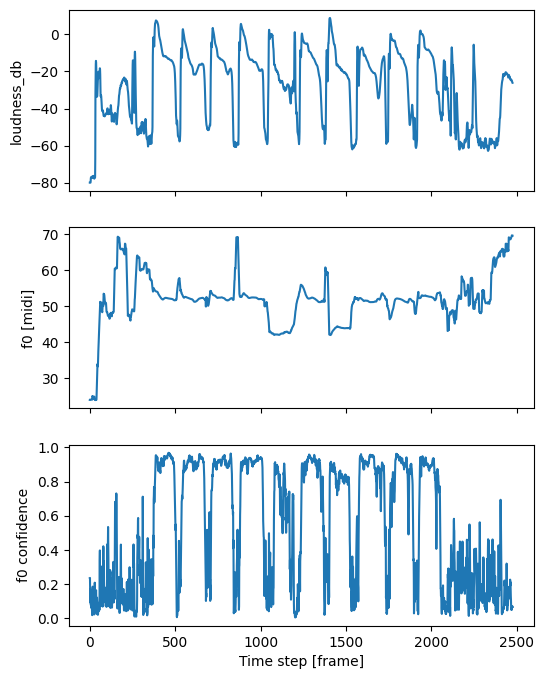

In [ ]:
#@title Record or Upload Audio
#@markdown * Either record audio from microphone or upload audio from file (.mp3 or .wav)
#@markdown * Audio should be monophonic (single instrument / voice)
#@markdown * Extracts fundmanetal frequency (f0) and loudness features.
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

record_or_upload = "Record"  #@param ["Record", "Upload (.mp3 or .wav)"]

record_seconds =     10#@param {type:"number", min:1, max:10, step:1}

if record_or_upload == "Record":
  audio = record(seconds=record_seconds)
else:
  # Load audio sample here (.mp3 or .wav3 file)
  # Just use the first file.
  filenames, audios = upload()
  audio = audios[0]
if len(audio.shape) == 1:
  audio = audio[np.newaxis, :]
print('\nExtracting audio features...')

# Plot.
specplot(audio)
play(audio)

# Setup the session.
ddsp.spectral_ops.reset_crepe()

# Compute features.
start_time = time.time()
audio_features = ddsp.training.metrics.compute_audio_features(audio)
audio_features['loudness_db'] = audio_features['loudness_db'].astype(np.float32)
audio_features_mod = None
print('Audio features took %.1f seconds' % (time.time() - start_time))


TRIM = -15
# Plot Features.
fig, ax = plt.subplots(nrows=3,
                       ncols=1,
                       sharex=True,
                       figsize=(6, 8))
ax[0].plot(audio_features['loudness_db'][:TRIM])
ax[0].set_ylabel('loudness_db')

ax[1].plot(librosa.hz_to_midi(audio_features['f0_hz'][:TRIM]))
ax[1].set_ylabel('f0 [midi]')

ax[2].plot(audio_features['f0_confidence'][:TRIM])
ax[2].set_ylabel('f0 confidence')
_ = ax[2].set_xlabel('Time step [frame]')

In [ ]:
#@title Load a model
#@markdown Run for ever new audio input
model = 'Upload your own (checkpoint folder as .zip)' #@param ['Upload your own (checkpoint folder as .zip)']
MODEL = model


def find_model_dir(dir_name):
  # Iterate through directories until model directory is found
  model_dir = None
  for root, dirs, filenames in os.walk(dir_name):
    for filename in filenames:
      if filename.endswith(".gin") and not filename.startswith("."):
        model_dir = root
        break
  return model_dir

model_dir = None  # Inizializzazione predefinita

if model in ('Bass', 'Guitar', 'Keyboard', 'Violin'):
  # Pretrained models.
  PRETRAINED_DIR = '/content/pretrained'
  # Copy over from gs:// for faster loading.
  !rm -r $PRETRAINED_DIR &> /dev/null
  !mkdir $PRETRAINED_DIR &> /dev/null
  GCS_CKPT_DIR = 'gs://ddsp/models/timbre_transfer_colab/2021-07-08'
  model_dir = os.path.join(GCS_CKPT_DIR, 'solo_%s_ckpt' % model.lower())

  !gsutil cp $model_dir/* $PRETRAINED_DIR &> /dev/null
  model_dir = PRETRAINED_DIR
  gin_file = os.path.join(model_dir, 'operative_config-0.gin')

else:
  # User models.
  UPLOAD_DIR = '/content/uploaded'
  !mkdir $UPLOAD_DIR
  uploaded_files = files.upload()

  for fnames in uploaded_files.keys():
    print("Unzipping... {}".format(fnames))
    !unzip -o "/content/$fnames" -d $UPLOAD_DIR &> /dev/null
  model_dir = find_model_dir(UPLOAD_DIR)
  gin_file = os.path.join(model_dir, 'operative_config-0.gin')

if model_dir is not None:
  # Load the dataset statistics.
  DATASET_STATS = None
  dataset_stats_file = os.path.join(model_dir, 'dataset_statistics.pkl')
  print(f'Loading dataset statistics from {dataset_stats_file}')
  try:
    if tf.io.gfile.exists(dataset_stats_file):
      with tf.io.gfile.GFile(dataset_stats_file, 'rb') as f:
        DATASET_STATS = pickle.load(f)
  except Exception as err:
    print('Loading dataset statistics from pickle failed: {}.'.format(err))



# Parse gin config,
with gin.unlock_config():
  gin.parse_config_file(gin_file, skip_unknown=True)

# Assumes only one checkpoint in the folder, 'ckpt-[iter]`.
ckpt_files = [f for f in tf.io.gfile.listdir(model_dir) if 'ckpt' in f]
ckpt_name = ckpt_files[0].split('.')[0]
ckpt = os.path.join(model_dir, ckpt_name)

# Ensure dimensions and sampling rates are equal
time_steps_train = gin.query_parameter('F0LoudnessPreprocessor.time_steps')
n_samples_train = gin.query_parameter('Harmonic.n_samples')
hop_size = int(n_samples_train / time_steps_train)

time_steps = int(audio.shape[1] / hop_size)
n_samples = time_steps * hop_size

# print("===Trained model===")
# print("Time Steps", time_steps_train)
# print("Samples", n_samples_train)
# print("Hop Size", hop_size)
# print("\n===Resynthesis===")
# print("Time Steps", time_steps)
# print("Samples", n_samples)
# print('')

gin_params = [
    'Harmonic.n_samples = {}'.format(n_samples),
    'FilteredNoise.n_samples = {}'.format(n_samples),
    'F0LoudnessPreprocessor.time_steps = {}'.format(time_steps),
    'oscillator_bank.use_angular_cumsum = True',  # Avoids cumsum accumulation errors.
]

with gin.unlock_config():
  gin.parse_config(gin_params)


# Trim all input vectors to correct lengths
for key in ['f0_hz', 'f0_confidence', 'loudness_db']:
  audio_features[key] = audio_features[key][:time_steps]
audio_features['audio'] = audio_features['audio'][:, :n_samples]


# Set up the model just to predict audio given new conditioning
model = ddsp.training.models.Autoencoder()
model.restore(ckpt)

# Build model by running a batch through it.
start_time = time.time()
_ = model(audio_features, training=False)
print('Restoring model took %.1f seconds' % (time.time() - start_time))

mkdir: cannot create directory ‘/content/uploaded’: File exists


Saving keyboard (2).zip to keyboard (2) (1).zip
Unzipping... keyboard (2) (1).zip
Loading dataset statistics from /content/uploaded/dataset_statistics.pkl
Restoring model took 1.0 seconds



Skipping auto-adujst (box not checked or no dataset statistics found).


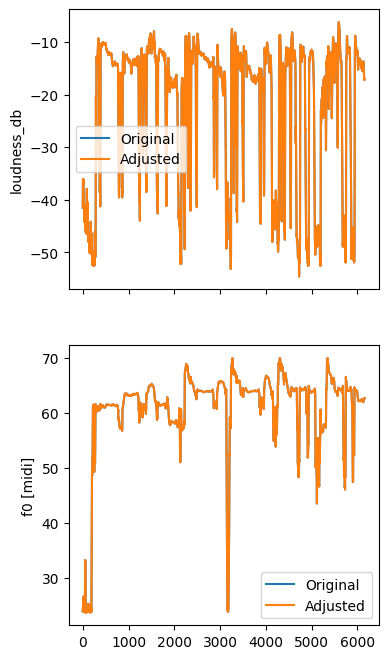

In [ ]:
#@title Modify conditioning

#@markdown These models were not explicitly trained to perform timbre transfer, so they may sound unnatural if the incoming loudness and frequencies are very different then the training data (which will always be somewhat true).


#@markdown ## Note Detection

#@markdown You can leave this at 1.0 for most cases
threshold = 1 #@param {type:"slider", min: 0.0, max:2.0, step:0.01}


#@markdown ## Automatic

ADJUST = True #@param{type:"boolean"}

#@markdown Quiet parts without notes detected (dB)
quiet = 20 #@param {type:"slider", min: 0, max:60, step:1}

#@markdown Force pitch to nearest note (amount)
autotune = 0 #@param {type:"slider", min: 0.0, max:1.0, step:0.1}

#@markdown ## Manual


#@markdown Shift the pitch (octaves)
pitch_shift =  0 #@param {type:"slider", min:-2, max:2, step:1}

#@markdown Adjust the overall loudness (dB)
loudness_shift = 0 #@param {type:"slider", min:-20, max:20, step:1}

import tensorflow as tf
audio_features_mod = {k: tf.identity(v) for k, v in audio_features.items()}


## Helper functions.
def shift_ld(audio_features, ld_shift=0.0):
  """Shift loudness by a number of ocatves."""
  audio_features['loudness_db'] += ld_shift
  return audio_features


def shift_f0(audio_features, pitch_shift=0.0):
  """Shift f0 by a number of ocatves."""
  audio_features['f0_hz'] *= 2.0 ** (pitch_shift)
  audio_features['f0_hz'] = np.clip(audio_features['f0_hz'],
                                    0.0,
                                    librosa.midi_to_hz(110.0))
  return audio_features


mask_on = None

if ADJUST and DATASET_STATS is not None:
  # Detect sections that are "on".
  mask_on, note_on_value = detect_notes(audio_features['loudness_db'],
                                        audio_features['f0_confidence'],
                                        threshold)

  if np.any(mask_on):
    # Shift the pitch register.
    target_mean_pitch = DATASET_STATS['mean_pitch']
    pitch = ddsp.core.hz_to_midi(audio_features['f0_hz'])
    mean_pitch = np.mean(pitch[mask_on])
    p_diff = target_mean_pitch - mean_pitch
    p_diff_octave = p_diff / 12.0
    round_fn = np.floor if p_diff_octave > 1.5 else np.ceil
    p_diff_octave = round_fn(p_diff_octave)
    audio_features_mod = shift_f0(audio_features_mod, p_diff_octave)


    # Quantile shift the note_on parts.
    _, loudness_norm = fit_quantile_transform(
        audio_features['loudness_db'],
        mask_on,
        inv_quantile=DATASET_STATS['quantile_transform'])

    # Turn down the note_off parts.
    mask_off = np.logical_not(mask_on)
    loudness_norm[mask_off] -=  quiet * (1.0 - note_on_value[mask_off][:, np.newaxis])
    loudness_norm = np.reshape(loudness_norm, audio_features['loudness_db'].shape)

    audio_features_mod['loudness_db'] = loudness_norm

    # Auto-tune.
    if autotune:
      f0_midi = np.array(ddsp.core.hz_to_midi(audio_features_mod['f0_hz']))
      tuning_factor = get_tuning_factor(f0_midi, audio_features_mod['f0_confidence'], mask_on)
      f0_midi_at = auto_tune(f0_midi, tuning_factor, mask_on, amount=autotune)
      audio_features_mod['f0_hz'] = ddsp.core.midi_to_hz(f0_midi_at)

  else:
    print('\nSkipping auto-adjust (no notes detected or ADJUST box empty).')

else:
  print('\nSkipping auto-adujst (box not checked or no dataset statistics found).')

# Manual Shifts.
audio_features_mod = shift_ld(audio_features_mod, loudness_shift)
audio_features_mod = shift_f0(audio_features_mod, pitch_shift)



# Plot Features.
has_mask = int(mask_on is not None)
n_plots = 3 if has_mask else 2
fig, axes = plt.subplots(nrows=n_plots,
                      ncols=1,
                      sharex=True,
                      figsize=(2*n_plots, 8))

if has_mask:
  ax = axes[0]
  ax.plot(np.ones_like(mask_on[:TRIM]) * threshold, 'k:')
  ax.plot(note_on_value[:TRIM])
  ax.plot(mask_on[:TRIM])
  ax.set_ylabel('Note-on Mask')
  ax.set_xlabel('Time step [frame]')
  ax.legend(['Threshold', 'Likelihood','Mask'])

ax = axes[0 + has_mask]
ax.plot(audio_features['loudness_db'][:TRIM])
ax.plot(audio_features_mod['loudness_db'][:TRIM])
ax.set_ylabel('loudness_db')
ax.legend(['Original','Adjusted'])

ax = axes[1 + has_mask]
ax.plot(librosa.hz_to_midi(audio_features['f0_hz'][:TRIM]))
ax.plot(librosa.hz_to_midi(audio_features_mod['f0_hz'][:TRIM]))
ax.set_ylabel('f0 [midi]')
_ = ax.legend(['Original','Adjusted'])


Prediction took 0.9 seconds
Original


Resynthesis


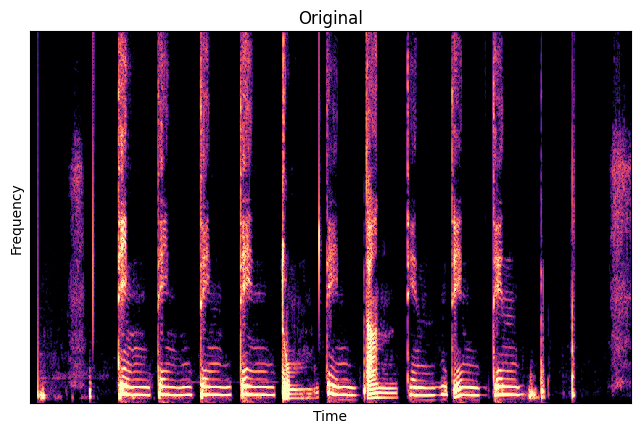

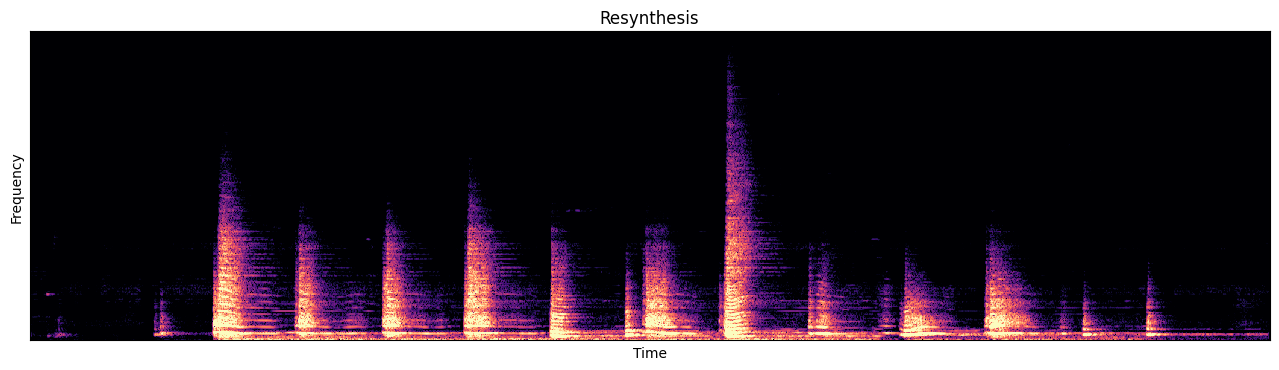

In [ ]:
#@title #Resynthesize Audio

af = audio_features if audio_features_mod is None else audio_features_mod

# Run a batch of predictions.
start_time = time.time()
outputs = model(af, training=False)
audio_gen = model.get_audio_from_outputs(outputs)
print('Prediction took %.1f seconds' % (time.time() - start_time))

# Plot
print('Original')
play(audio)

print('Resynthesis')
play(audio_gen)

specplot(audio)
plt.title("Original")

specplot(audio_gen)
_ = plt.title("Resynthesis")